<a href="https://colab.research.google.com/github/Lin-Feihan/Finrl_demo/blob/main/Finrl_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -q yfinance stable-baselines3[extra] gym pandas matplotlib
!pip install -q yfinance stable-baselines3[extra] gym shimmy pandas matplotlib

In [6]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

TICKERS = ["AAPL", "MSFT"]
START = "2018-01-01"
END = "2022-12-31"

df = yf.download(TICKERS, start=START, end=END)['Close']
df = df.dropna()
df.head()


/tmp/ipython-input-3959307162.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(TICKERS, start=START, end=END)['Close']
[                       0%                       ]/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
[*********************100%***********************]  2 of 2 completed
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Ticker,AAPL,MSFT
Date,,
2018-01-02,40.380997,79.198326
2018-01-03,40.373959,79.566895
2018-01-04,40.561493,80.267197
2018-01-05,41.023296,81.262398
2018-01-08,40.870941,81.345291


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
import gym
from gym import spaces

class MultiStockEnv(gym.Env):
    def __init__(self, df, initial_balance=10000, transaction_cost=0.001):
        super().__init__()
        self.df = df.reset_index(drop=True)
        self.tickers = df.columns.tolist()
        self.n_assets = len(self.tickers)
        self.initial_balance = initial_balance
        self.transaction_cost = transaction_cost
        self.max_step = len(self.df) - 1

        # state: [prices..., holdings..., cash]
        self.observation_space = spaces.Box(
            low=0, high=np.inf, shape=(self.n_assets*2+1,), dtype=np.float32
        )
        # action: 每个股票买/卖/持有 (3 choices per asset)
        self.action_space = spaces.MultiDiscrete([3]*self.n_assets)

        self.reset()

    def _get_obs(self):
        prices = self.df.loc[self.current_step, self.tickers].values
        return np.array(list(prices) + list(self.holdings) + [self.cash], dtype=np.float32)

    def step(self, actions):
        done = False
        prices = self.df.loc[self.current_step, self.tickers].values
        prev_net = self.net_worth

        for i, action in enumerate(actions):
            if action == 1:  # buy 1
                if self.cash >= prices[i]:
                    self.cash -= prices[i]*(1+self.transaction_cost)
                    self.holdings[i] += 1
            elif action == 2:  # sell 1
                if self.holdings[i] > 0:
                    self.cash += prices[i]*(1-self.transaction_cost)
                    self.holdings[i] -= 1

        self.current_step += 1
        next_prices = self.df.loc[self.current_step, self.tickers].values
        self.net_worth = self.cash + np.sum(self.holdings * next_prices)
        reward = self.net_worth - prev_net

        if self.current_step >= self.max_step:
            done = True

        return self._get_obs(), reward, done, {}

    def reset(self):
        self.current_step = 0
        self.cash = self.initial_balance
        self.holdings = np.zeros(self.n_assets, dtype=np.int32)
        self.net_worth = self.initial_balance
        return self._get_obs()


In [8]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env = DummyVecEnv([lambda: MultiStockEnv(df)])

model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=20000)  # 可增加训练步数


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 607  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 522          |
|    iterations           | 2            |
|    time_elapsed         | 7            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0075540342 |
|    clip_fraction        | 0.0411       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    explained_variance   | 7.1e-05      |
|    learning_rate        | 0.0003       |
|    loss                 | 2.5e+04      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00448     |
|    value_loss           | 6.57e+04     |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 515         |
|    iterations           | 3           |
|    time_elapsed         | 11          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.006931967 |
|    clip_fraction        | 0.00083     |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | 0.0014      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.94e+04    |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.00219    |
|    value_loss           | 1.26e+05    |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-----------------------------------------
| time/                   |             |
|    fps                  | 508         |
|    iterations           | 4           |
|    time_elapsed         | 16          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.008724738 |
|    clip_fraction        | 0.0344      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | 0.00124     |
|    learning_rate        | 0.0003      |
|    loss                 | 7.37e+04    |
|    n_updates            | 30          |
|    policy_gradient_loss | -0.00578    |
|    value_loss           | 1.4e+05     |
-----------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 496          |
|    iterations           | 5            |
|    time_elapsed         | 20           |
|    total_timesteps      | 10240        |
| train/                  |              |
|    approx_kl            | 0.0017065927 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.17        |
|    explained_variance   | -0.000214    |
|    learning_rate        | 0.0003       |
|    loss                 | 2.05e+05     |
|    n_updates            | 40           |
|    policy_gradient_loss | -0.00243     |
|    value_loss           | 4.59e+05     |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 495           |
|    iterations           | 6             |
|    time_elapsed         | 24            |
|    total_timesteps      | 12288         |
| train/                  |               |
|    approx_kl            | 0.00021311911 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.17         |
|    explained_variance   | 0.00165       |
|    learning_rate        | 0.0003        |
|    loss                 | 2.54e+05      |
|    n_updates            | 50            |
|    policy_gradient_loss | -0.000735     |
|    value_loss           | 5.24e+05      |
-------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 490           |
|    iterations           | 7             |
|    time_elapsed         | 29            |
|    total_timesteps      | 14336         |
| train/                  |               |
|    approx_kl            | 0.00036901535 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.17         |
|    explained_variance   | 0.000759      |
|    learning_rate        | 0.0003        |
|    loss                 | 1.7e+05       |
|    n_updates            | 60            |
|    policy_gradient_loss | -0.000754     |
|    value_loss           | 5.06e+05      |
-------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


------------------------------------------
| time/                   |              |
|    fps                  | 488          |
|    iterations           | 8            |
|    time_elapsed         | 33           |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 9.803724e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.17        |
|    explained_variance   | 0.00327      |
|    learning_rate        | 0.0003       |
|    loss                 | 3.66e+05     |
|    n_updates            | 70           |
|    policy_gradient_loss | -0.000666    |
|    value_loss           | 4.86e+05     |
------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 486           |
|    iterations           | 9             |
|    time_elapsed         | 37            |
|    total_timesteps      | 18432         |
| train/                  |               |
|    approx_kl            | 1.8817693e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.17         |
|    explained_variance   | 0.00468       |
|    learning_rate        | 0.0003        |
|    loss                 | 3.69e+05      |
|    n_updates            | 80            |
|    policy_gradient_loss | -0.000272     |
|    value_loss           | 7.51e+05      |
-------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


-------------------------------------------
| time/                   |               |
|    fps                  | 479           |
|    iterations           | 10            |
|    time_elapsed         | 42            |
|    total_timesteps      | 20480         |
| train/                  |               |
|    approx_kl            | 0.00017462712 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.16         |
|    explained_variance   | 0.00539       |
|    learning_rate        | 0.0003        |
|    loss                 | 1.22e+05      |
|    n_updates            | 90            |
|    policy_gradient_loss | -0.000675     |
|    value_loss           | 4.1e+05       |
-------------------------------------------


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


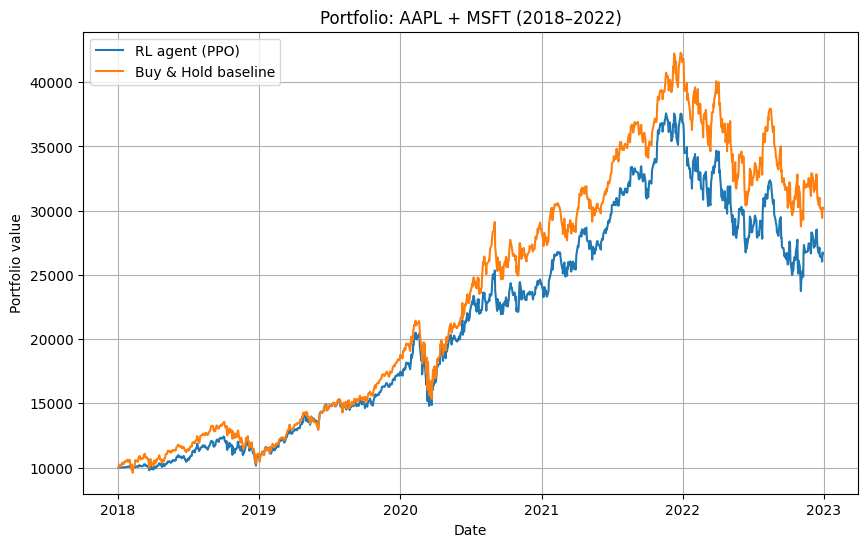

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


<Figure size 640x480 with 0 Axes>

In [9]:
eval_env = MultiStockEnv(df)
obs = eval_env.reset()
rl_values = [eval_env.net_worth]

done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _ = eval_env.step(action)
    rl_values.append(eval_env.net_worth)

# Buy&Hold baseline（初始资金尽量均匀买两只股票）
initial_prices = df.iloc[0].values
shares = (eval_env.initial_balance // (initial_prices.sum())) * np.ones(len(TICKERS))
cash_left = eval_env.initial_balance - np.sum(shares * initial_prices)
bh_values = (shares * df.values).sum(axis=1) + cash_left

dates = df.index[:len(rl_values)]

plt.figure(figsize=(10,6))
plt.plot(dates, rl_values, label='RL agent (PPO)')
plt.plot(dates, bh_values[:len(rl_values)], label='Buy & Hold baseline')
plt.legend()
plt.title("Portfolio: AAPL + MSFT (2018–2022)")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.grid(True)
plt.show()

plt.savefig("result.png")
